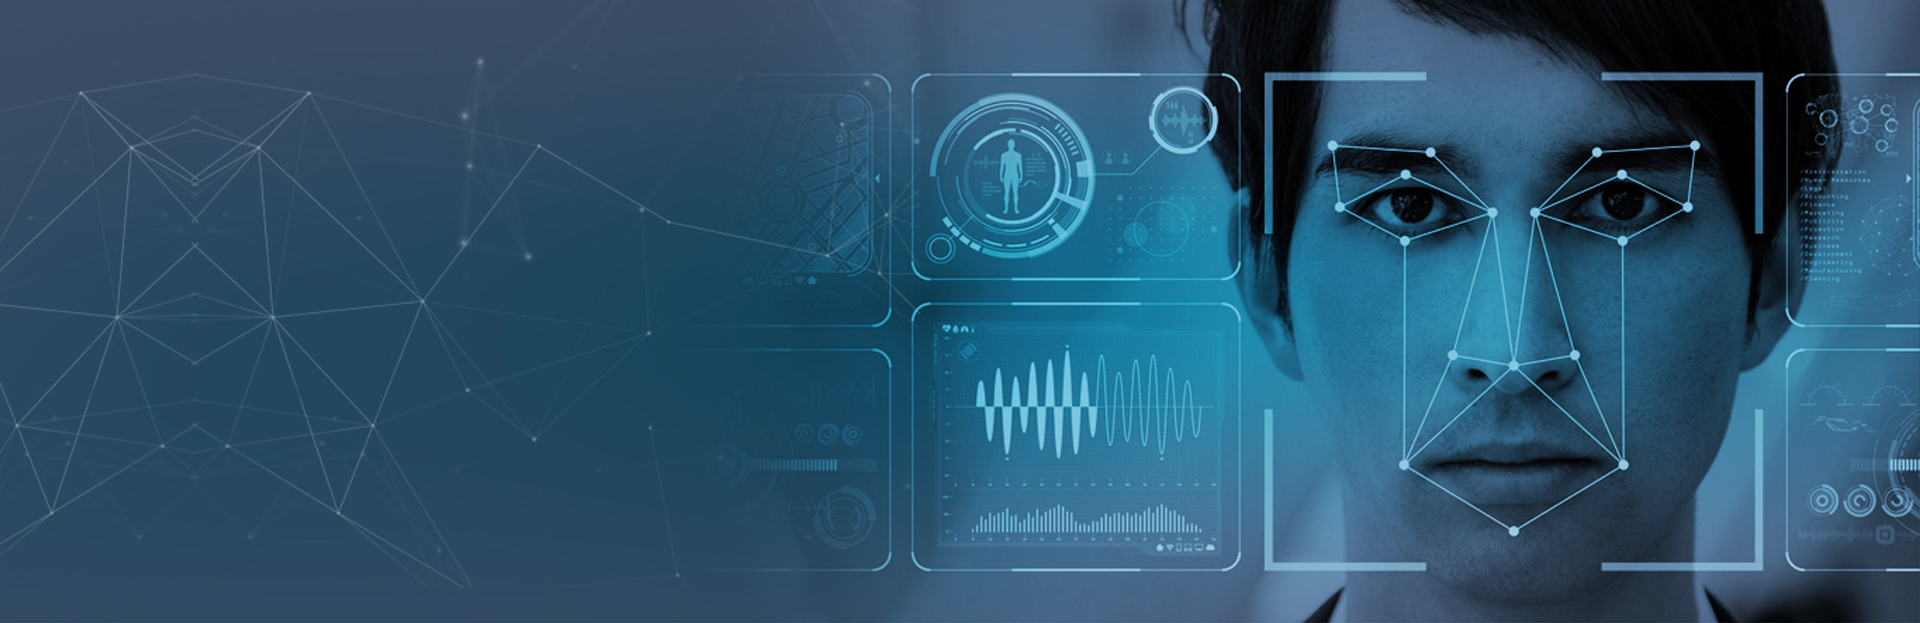

### *Objective*
-----
**The objective of this project is to build a model that will give us an output whether a person wear a mask or not.
We have to test it on video as well as on some images to valitadate or model more.**

In [1]:
from keras.applications.mobilenet import MobileNet  #designed for mobile and embedded vision applications(fast to use)
from keras.preprocessing import image              #Because our i/p is images
from keras.preprocessing.image import ImageDataGenerator, load_img   #It will help to do data augmentation
import keras
from keras.applications.vgg16 import preprocess_input, decode_predictions  
from keras.layers import *
from keras.callbacks import *
from keras.models import Model
from keras.models import Sequential        #We are creating a sequential model
import numpy as np
import pandas as pd
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Exploring data

In [2]:
data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [3]:
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        x = image.img_to_array(img)

        try:
            data.append(x)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [4]:
data=np.array(data)/255.0
data = np.array(data, dtype="float32")
print(f"data_shape : {data.shape}")
target = np.array(target)      
print(f"label_shape : {target.shape}")
      
"""
(number of images,expanded_dim,image_format)
image_format=(224,224,3):- RGB image

"""

data_shape : (1376, 224, 224, 3)
label_shape : (1376,)


'\n(number of images,expanded_dim,image_format)\nimage_format=(224,224,3):- RGB image\n\n'

In [5]:
# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

lb = LabelBinarizer()
target = lb.fit_transform(target)
target = to_categorical(target)
target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [6]:
#Train-Test Split
from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(data, target,test_size=0.20, random_state=10)

In [7]:
# construct the training image generator for data augmentation

aug = ImageDataGenerator(rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

In [8]:
# Creting F1 matrix for optimum solution

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Making a model using transfer learning

In [9]:
#Modeling

IMAGE_SIZE=[224,224]
pretrained_model = MobileNet(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False # tramsfer learning
    #enet = efn.EfficientNetB7(input_shape=(512, 512, 3),weights='imagenet',include_top=False)
    
model = Sequential([
        pretrained_model,
        AveragePooling2D(pool_size=(7, 7)),
        Flatten(name="flatten"),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

es = keras.callbacks.EarlyStopping(monitor='val_f1_m', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

model.compile(optimizer ='Adam', loss='binary_crossentropy', metrics=[f1_m])    
His=model.fit(aug.flow(train_data, train_target),
        steps_per_epoch=len(train_data) // 32,
        validation_data=(test_data, test_target),
        validation_steps=len(test_data) // 32,
        epochs=20,
        callbacks=[es])


Epoch 1/20
34/34 [==============================] - 87s 3s/step - loss: 0.2607 - f1_m: 0.8909 - val_loss: 0.0251 - val_f1_m: 0.9896
Epoch 2/20
34/34 [==============================] - 85s 2s/step - loss: 0.1453 - f1_m: 0.9427 - val_loss: 0.0757 - val_f1_m: 0.9722
Epoch 3/20
34/34 [==============================] - 81s 2s/step - loss: 0.0743 - f1_m: 0.9764 - val_loss: 0.0156 - val_f1_m: 0.9965
Epoch 4/20
34/34 [==============================] - 87s 3s/step - loss: 0.0419 - f1_m: 0.9853 - val_loss: 0.0097 - val_f1_m: 0.9965
Epoch 5/20
34/34 [==============================] - 83s 2s/step - loss: 0.0451 - f1_m: 0.9807 - val_loss: 0.0301 - val_f1_m: 0.9826


In [10]:
predIdxs = model.predict(test_data)
predIdxs = np.argmax(predIdxs, axis=1)

In [11]:
confusion_matrix_graph = confusion_matrix(test_target.argmax(axis=1), predIdxs)
confusion_matrix_graph

array([[139,   0],
       [  5, 132]], dtype=int64)

In [12]:
cm_pd=pd.DataFrame(confusion_matrix_graph,index=["positive","Negative"],columns=["positive","Negative"])
cm_pd

,positive,Negative
positive,139,0
Negative,5,132


In [13]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(test_target.argmax(axis=1),predIdxs)
print('Accuracy: %f' % accuracy)
from sklearn.metrics import precision_score
precision=precision_score(test_target.argmax(axis=1),predIdxs)
print('Precision: %f' % precision)
from sklearn.metrics import recall_score
recall=recall_score(test_target.argmax(axis=1),predIdxs)
print('Recall: %f' % recall)                    
from sklearn.metrics import f1_score
F1=f1_score(test_target.argmax(axis=1),predIdxs)
print('F1 score: %f' % F1)

Accuracy: 0.981884
Precision: 1.000000
Recall: 0.963504
F1 score: 0.981413


In [14]:
#Getting the best model

mc = ModelCheckpoint('best_model.h5', monitor='val_f1_m', mode='auto', verbose=1, save_best_only=True)
His=model.fit(aug.flow(train_data, train_target),
        steps_per_epoch=len(train_data) // 32,
        validation_data=(test_data, test_target),
        validation_steps=len(test_data) // 32,
        epochs=20,
        callbacks=[es,mc])

Epoch 1/20
34/34 [==============================] - 83s 2s/step - loss: 0.0298 - f1_m: 0.9899 - val_loss: 0.0146 - val_f1_m: 0.9965

Epoch 00001: val_f1_m improved from inf to 0.99653, saving model to best_model.h5
Epoch 2/20
34/34 [==============================] - 83s 2s/step - loss: 0.0293 - f1_m: 0.9871 - val_loss: 0.0197 - val_f1_m: 0.9931

Epoch 00002: val_f1_m improved from 0.99653 to 0.99306, saving model to best_model.h5
Epoch 3/20
34/34 [==============================] - 81s 2s/step - loss: 0.0346 - f1_m: 0.9871 - val_loss: 0.0034 - val_f1_m: 1.0000

Epoch 00003: val_f1_m did not improve from 0.99306
Epoch 4/20
34/34 [==============================] - 83s 2s/step - loss: 0.0273 - f1_m: 0.9902 - val_loss: 0.0302 - val_f1_m: 0.9855

Epoch 00004: val_f1_m improved from 0.99306 to 0.98551, saving model to best_model.h5
Epoch 5/20
34/34 [==============================] - 80s 2s/step - loss: 0.0260 - f1_m: 0.9936 - val_loss: 0.0250 - val_f1_m: 0.9861

Epoch 00005: val_f1_m did not 

**Using callback to get the best model**

In [15]:
# for best model
# load the saved model
from keras.models import load_model
dependencies = {
     'f1_m': f1_m
}
saved_model = load_model('best_model.h5',custom_objects=dependencies)

C:\Users\vkaush2\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [16]:
pred_best=saved_model.predict(test_data)
pred_best = np.argmax(pred_best, axis=1)

In [17]:
confusion_matrix_graph = confusion_matrix(test_target.argmax(axis=1), predIdxs)
confusion_matrix_graph

array([[139,   0],
       [  5, 132]], dtype=int64)

## Load images to check

In [18]:
import pkg_resources
haar_xml = pkg_resources.resource_filename('cv2', 
                    'data/haarcascade_frontalface_default.xml')

In [19]:
haar_xml

'C:\\Users\\vkaush2\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml'

### Model to check mask detection on video

In [59]:
face_cascade = cv2.CascadeClassifier('C:\\Users\\vkaush2\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('C:\\Users\\vkaush2\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\cv2\\data\\haarcascade_eye.xml')

source=cv2.VideoCapture(0)

labels_dict={1:'MASK',0:'NO MASK'}

color_dict={1:(0,255,0),0:(0,0,255)}
while(True):

    ret,img=source.read()
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    """
    when we display the image using matplotlib, the red and blue channel gets swapped and hence the blue tinge. 
    Using cvtcolur solve this issue
    
    """
    faces=face_cascade.detectMultiScale(img_rgb,scaleFactor=1.1, minNeighbors=4)  

    for (x,y,w,h) in faces:
    
        face_img=img_rgb[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,224,224,3))
        result=saved_model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):   # wait for ESC key to exit
        break
        
cv2.destroyAllWindows()
source.release()

In [ ]:
#To recognize face and eyes basic practice

"""
cap = cv2.VideoCapture(0)

while 1:
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        

        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]

        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


    cv2.imshow('img',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:   # wait for ESC key to exit
        break

cap.release()
cv2.destroyAllWindows()

"""

## Checking for test image

 height=450,width=800, depth=3


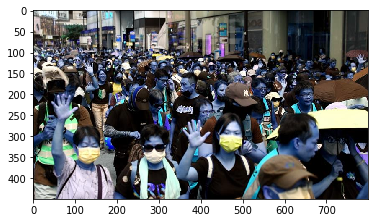

In [52]:
source=cv2.imread('e35d1b65f1ee4f7f9a3d75a2662cc32d_18.jpg')
(h, w, d) = source.shape
print(" height={},width={}, depth={}".format( h,w, d))
plt.imshow(source)

In [56]:
labels_dict={1:'MASK',0:'NO MASK'}

color_dict={1:(0,255,0),0:(0,0,255)}
while(True):

    img=source
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces=face_cascade.detectMultiScale(img_rgb,scaleFactor=1.1, minNeighbors=4)  

    for (x,y,w,h) in faces:
    
        face_img=img_rgb[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,224,224,3))
        result=saved_model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):   # wait for ESC key to exit
        break
        
cv2.destroyAllWindows()
#source.release()

 height=571,width=855, depth=3


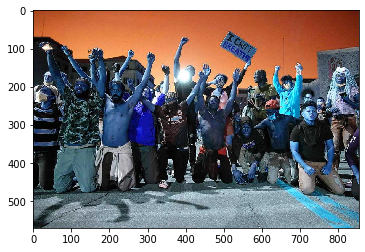

In [57]:
source=cv2.imread('Protests_1_20200530_571_855.jpg')
(h, w, d) = source.shape
print(" height={},width={}, depth={}".format( h,w, d))
plt.imshow(source)

In [58]:
labels_dict={1:'MASK',0:'NO MASK'}

color_dict={1:(0,255,0),0:(0,0,255)}
while(True):

    img=source
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces=face_cascade.detectMultiScale(img_rgb,scaleFactor=1.1, minNeighbors=4)  

    for (x,y,w,h) in faces:
    
        face_img=img_rgb[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,224,224,3))
        result=saved_model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):   # wait for ESC key to exit
        break
        
cv2.destroyAllWindows()
#source.release()

#### Improvement:-
1. Need to train deep model for better accuracy.
2. Dataset for training the model must consist group photos of people with mask and without mask.
3. Need a dataset with people of different ages for better accuracy.


### Result:-
1. Working well with video images.
2. working well with an image or video of few people.
2. Need improvement in group image detection.